In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mapFeature import mapFeature
from plotDecisionBoundary import plotDecisionBoundary

## Logistic regression

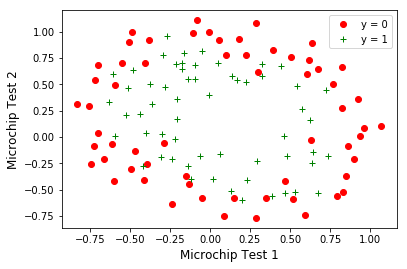

IndexError: tuple index out of range

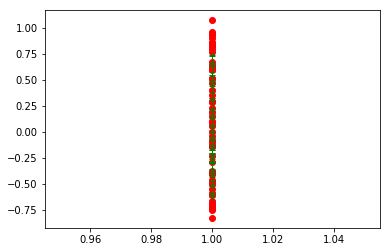

In [2]:
# load the data
data = np.loadtxt('ex2data2.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2].reshape((-1,1))

index0 = np.where(y==0)[0]
index1 = np.where(y==1)[0]

# plot the data
plt.plot(X[index0,0], X[index0,1], 'ro')
plt.plot(X[index1,0], X[index1,1], 'g+')
plt.xlabel('Microchip Test 1', fontsize=12)
plt.ylabel('Microchip Test 2', fontsize=12)
plt.legend(['y = 0', 'y = 1'])
plt.show()

# the data points that are not% linearly separable. However, you would still like to use logistic
# regression to classify the data points
# to do so, you introduce more features to use -- in particular, you add
# polynomial features to our data matrix (similar to polynomial regression).
# note that mapFeature also adds a column of ones for us, so the intercept
# term is handled
degree = 6
Xdata = mapFeature(X[:,0], X[:,1], degree)

theta = np.zeros((Xdata.shape[1],1))
plotDecisionBoundary(theta, Xdata, y, degree)